In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid", context="talk")

NOTEBOOK_DIR = Path.cwd().resolve()
BASE_DIR = NOTEBOOK_DIR.parent

RESULTS_DIR = BASE_DIR / "notebooks" / "results"

LABEL_COLUMN = "Label"

DATASET_MODE_CSV: Dict[str, Dict[str, Path]] = {
    "full": {
        "off": RESULTS_DIR / "full" / "off" / "xss_full_with_api_results.csv",
        "log": RESULTS_DIR / "full" / "log" / "xss_full_with_api_results.csv",
        "block": RESULTS_DIR / "full" / "block" / "xss_full_with_api_results.csv",
    },
    "github": {
        "off": RESULTS_DIR / "github" / "off" / "xss_github_with_api_results.csv",
        "log": RESULTS_DIR / "github" / "log" / "xss_github_with_api_results.csv",
        "block": RESULTS_DIR / "github" / "block" / "xss_github_with_api_results.csv",
    },
    "kaggle": {
        "off": RESULTS_DIR / "kaggle" / "off" / "xss_kaggle_with_api_results.csv",
        "log": RESULTS_DIR / "kaggle" / "log" / "xss_kaggle_with_api_results.csv",
        "block": RESULTS_DIR / "kaggle" / "block" / "xss_kaggle_with_api_results.csv",
    },
}

dfs: Dict[str, Dict[str, pd.DataFrame]] = {}

for dataset, modes in DATASET_MODE_CSV.items():
    dfs[dataset] = {}
    for mode, path in modes.items():
        if not path.exists():
            raise FileNotFoundError(f"Results not found for dataset={dataset} mode={mode}: {path}")
        df_mode = pd.read_csv(path)
        dfs[dataset][mode] = df_mode
        print(f"[INFO] Loaded dataset={dataset} mode={mode}: shape={df_mode.shape}")

dfs["full"]["off"].head()


[INFO] Loaded dataset=full mode=off: shape=(15351, 18)
[INFO] Loaded dataset=full mode=log: shape=(15351, 18)
[INFO] Loaded dataset=full mode=block: shape=(15351, 18)
[INFO] Loaded dataset=github mode=off: shape=(4516, 18)
[INFO] Loaded dataset=github mode=log: shape=(4516, 18)
[INFO] Loaded dataset=github mode=block: shape=(4516, 18)
[INFO] Loaded dataset=kaggle mode=off: shape=(10835, 18)
[INFO] Loaded dataset=kaggle mode=log: shape=(10835, 18)
[INFO] Loaded dataset=kaggle mode=block: shape=(10835, 18)


,Sentence_clean,Label,families_str,len_after_clean,source,family_main,has_script_tag,has_event,has_js_uri,has_iframe,api_original,api_sanitized,api_blocked,api_category,api_mode,api_error,api_error_message,api_raw_json
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0,image_tag,557,kaggle,benign,False,False,False,False,"<li><a href=""/wiki/File:Socrates.png"" class=""i...","<li><a href=""/wiki/File:Socrates.png"" class=""i...",False,benign,off,NaN,NaN,"{""original"": ""<li><a href=\""/wiki/File:Socrate..."
1,"<tt onmouseover=""alert(1)"">test</tt>",1,event_handler,36,kaggle,event,False,True,False,False,"<tt onmouseover=""alert(1)"">test</tt>","<tt onmouseover=""alert(1)"">test</tt>",False,event,off,NaN,NaN,"{""original"": ""<tt onmouseover=\""alert(1)\"">tes..."
2,"</span> <span class=""reference-text"">Steering ...",0,other,230,kaggle,benign,False,False,False,False,"</span> <span class=""reference-text"">Steering ...","</span> <span class=""reference-text"">Steering ...",False,benign,off,NaN,NaN,"{""original"": ""</span> <span class=\""reference-..."
3,"</span> <span class=""reference-text""><cite cla...",0,maybe_polyglot,392,kaggle,benign,False,False,False,False,"</span> <span class=""reference-text""><cite cla...","</span> <span class=""reference-text""><cite cla...",False,benign,off,NaN,NaN,"{""original"": ""</span> <span class=\""reference-..."
4,"</span>. <a href=""/wiki/Digital_object_identif...",0,other,419,kaggle,benign,False,False,False,False,"</span>. <a href=""/wiki/Digital_object_identif...","</span>. <a href=""/wiki/Digital_object_identif...",False,benign,off,NaN,NaN,"{""original"": ""</span>. <a href=\""/wiki/Digital..."


In [2]:
def compute_confusion(df: pd.DataFrame, label_col: str = LABEL_COLUMN) -> dict:
    y_true = df[label_col].astype(int)
    y_pred = df["api_blocked"].astype(bool).astype(int)

    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    tn = ((y_true == 0) & (y_pred == 0)).sum()

    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    fnr = fn / (tp + fn) if (tp + fn) else 0.0
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (fp + tn) if (fp + tn) else 0.0

    precision = tp / (tp + fp) if (tp + fp) else 0.0
    f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0.0

    return {
        "tp": tp,
        "fn": fn,
        "fp": fp,
        "tn": tn,
        "recall_xss": tpr,
        "miss_rate_xss": fnr,
        "fpr": fpr,
        "tnr": tnr,
        "precision": precision,
        "f1": f1,
    }

rows = []
for dataset, modes in dfs.items():
    for mode, df_mode in modes.items():
        metrics = compute_confusion(df_mode)
        metrics["dataset"] = dataset
        metrics["mode"] = mode
        rows.append(metrics)

df_metrics_all = (
    pd.DataFrame(rows)
    .set_index(["dataset", "mode"])
    .sort_index()
)

df_metrics_all


tp     fn   fp    tn  recall_xss  miss_rate_xss       fpr  \
dataset mode                                                                  
full    block  11404    299  148  3500    0.974451       0.025549  0.040570   
        log        0  11703    0  3648    0.000000       1.000000  0.000000   
        off        0  11703    0  3648    0.000000       1.000000  0.000000   
github  block   4147    238  105    26    0.945724       0.054276  0.801527   
        log        0   4385    0   131    0.000000       1.000000  0.000000   
        off        0   4385    0   131    0.000000       1.000000  0.000000   
kaggle  block   7257     61   43  3474    0.991664       0.008336  0.012226   
        log        0   7318    0  3517    0.000000       1.000000  0.000000   
        off        0   7318    0  3517    0.000000       1.000000  0.000000   

                    tnr  precision        f1  
dataset mode                                  
full    block  0.959430   0.987188  0.980778  
        log    1.000000   0.000000  0.000000  
        off    1.000000   0.000000  0.000000  
github  block  0.198473   0.975306  0.960287  
        log    1.000000   0.000000  0.000000  
        off    1.000000   0.000000  0.000000  
kaggle  block  0.987774   0.994110  0.992885  
        log    1.000000   0.000000  0.000000  
        off    1.000000   0.000000  0.000000

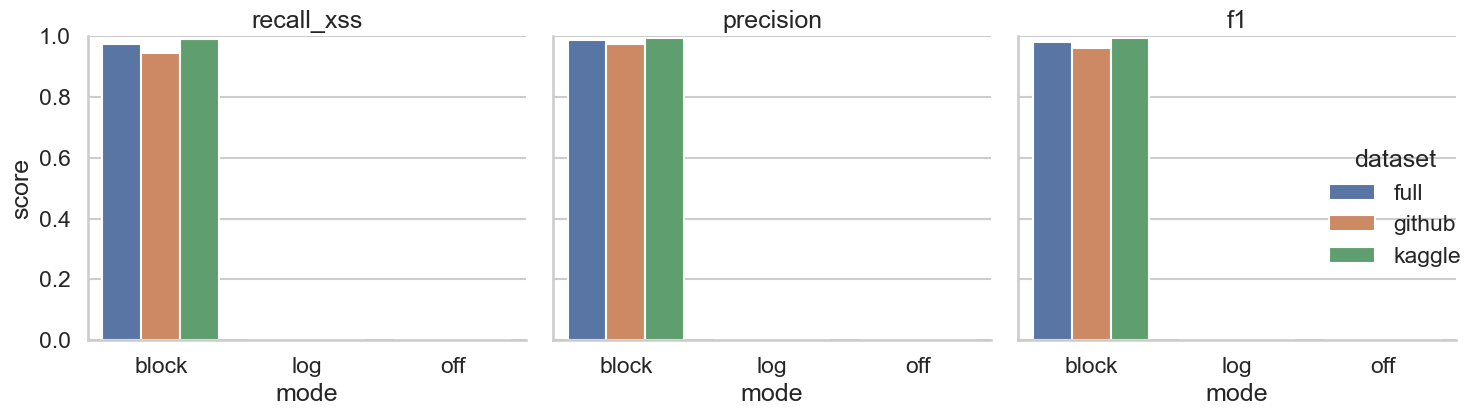

In [3]:
metrics_to_plot = ["recall_xss", "precision", "f1"]

df_plot = (
    df_metrics_all.reset_index()
    .melt(
        id_vars=["dataset", "mode"],
        value_vars=metrics_to_plot,
        var_name="metric",
        value_name="score",
    )
)

g = sns.catplot(
    data=df_plot,
    x="mode",
    y="score",
    hue="dataset",
    col="metric",
    kind="bar",
    height=4.5,
    aspect=1.0,
)
g.set_titles("{col_name}")
g.set_axis_labels("mode", "score")
for ax in g.axes.flatten():
    ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


In [4]:
def summarize_by_family(df_mode: pd.DataFrame) -> pd.DataFrame:
    df_eval = df_mode.copy()
    df_eval["y_true"] = df_eval[LABEL_COLUMN].astype(int)
    df_eval["y_pred"] = df_eval["api_blocked"].astype(bool).astype(int)

    rows = []
    for fam, g in df_eval.groupby("family_main"):
        tp = ((g["y_true"] == 1) & (g["y_pred"] == 1)).sum()
        fn = ((g["y_true"] == 1) & (g["y_pred"] == 0)).sum()
        fp = ((g["y_true"] == 0) & (g["y_pred"] == 1)).sum()
        tn = ((g["y_true"] == 0) & (g["y_pred"] == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0

        rows.append(
            {
                "family_main": fam,
                "n": len(g),
                "tp": tp,
                "fn": fn,
                "fp": fp,
                "tn": tn,
                "recall_xss": tpr,
                "fpr": fpr,
            }
        )

    return pd.DataFrame(rows).sort_values("n", ascending=False)

all_family_tables: Dict[str, pd.DataFrame] = {}
all_family_rows = []

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    df_family = summarize_by_family(df_block)
    df_family["dataset"] = dataset
    all_family_tables[dataset] = df_family
    all_family_rows.append(df_family)

df_family_all = pd.concat(all_family_rows, ignore_index=True)
df_family_all


,family_main,n,tp,fn,fp,tn,recall_xss,fpr,dataset
0,event,7667,7630,29,6,2,0.996214,0.750000,full
1,benign,4030,134,270,128,3498,0.331683,0.035301,full
2,script,3408,3394,0,14,0,1.000000,1.000000,full
3,iframe,210,210,0,0,0,1.000000,0.000000,full
4,js_uri,36,36,0,0,0,1.000000,0.000000,full
5,script,3309,3309,0,0,0,1.000000,0.000000,github
6,event,561,532,29,0,0,0.948307,0.000000,github
7,benign,439,99,209,105,26,0.321429,0.801527,github
8,iframe,207,207,0,0,0,1.000000,0.000000,github
9,event,7106,7098,0,6,2,1.000000,0.750000,kaggle


In [5]:
for dataset, table in all_family_tables.items():
    print(f"\n=== Family summary — dataset={dataset} ===")
    display(table)



=== Family summary — dataset=full ===


,family_main,n,tp,fn,fp,tn,recall_xss,fpr,dataset
1,event,7667,7630,29,6,2,0.996214,0.750000,full
0,benign,4030,134,270,128,3498,0.331683,0.035301,full
4,script,3408,3394,0,14,0,1.000000,1.000000,full
2,iframe,210,210,0,0,0,1.000000,0.000000,full
3,js_uri,36,36,0,0,0,1.000000,0.000000,full



=== Family summary — dataset=github ===


,family_main,n,tp,fn,fp,tn,recall_xss,fpr,dataset
3,script,3309,3309,0,0,0,1.000000,0.000000,github
1,event,561,532,29,0,0,0.948307,0.000000,github
0,benign,439,99,209,105,26,0.321429,0.801527,github
2,iframe,207,207,0,0,0,1.000000,0.000000,github



=== Family summary — dataset=kaggle ===


,family_main,n,tp,fn,fp,tn,recall_xss,fpr,dataset
1,event,7106,7098,0,6,2,1.000000,0.750000,kaggle
0,benign,3591,35,61,23,3472,0.364583,0.006581,kaggle
4,script,99,85,0,14,0,1.000000,1.000000,kaggle
3,js_uri,36,36,0,0,0,1.000000,0.000000,kaggle
2,iframe,3,3,0,0,0,1.000000,0.000000,kaggle


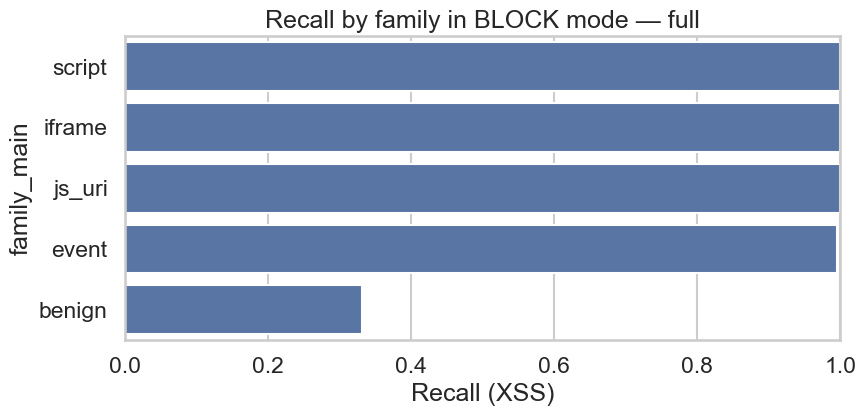

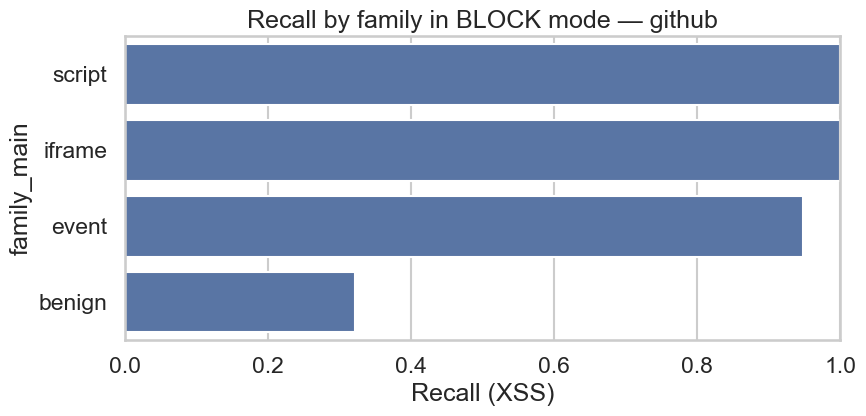

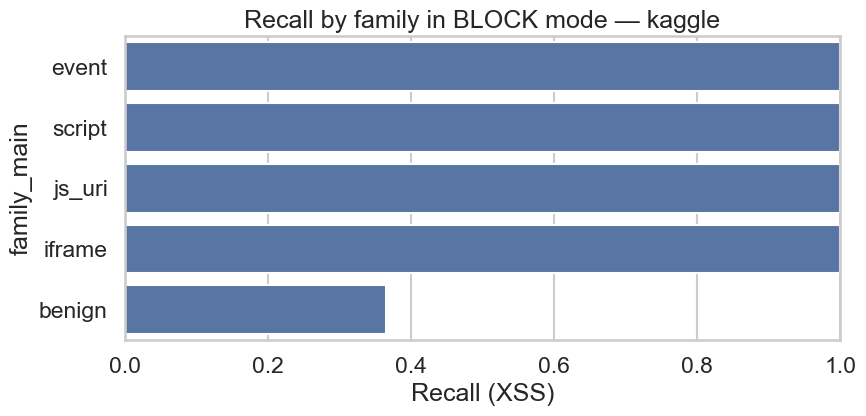

In [6]:
for dataset, table in all_family_tables.items():
    plt.figure(figsize=(9, 4.5))
    ordered = table.sort_values("recall_xss", ascending=False)
    sns.barplot(
        data=ordered,
        x="recall_xss",
        y="family_main",
    )
    plt.title(f"Recall by family in BLOCK mode — {dataset}")
    plt.xlim(0, 1)
    plt.xlabel("Recall (XSS)")
    plt.ylabel("family_main")
    plt.tight_layout()
    plt.show()


In [7]:
def summarize_by_source(df_mode: pd.DataFrame) -> pd.DataFrame:
    df_eval = df_mode.copy()
    df_eval["y_true"] = df_eval[LABEL_COLUMN].astype(int)
    df_eval["y_pred"] = df_eval["api_blocked"].astype(bool).astype(int)

    rows = []
    for src, g in df_eval.groupby("source"):
        tp = ((g["y_true"] == 1) & (g["y_pred"] == 1)).sum()
        fn = ((g["y_true"] == 1) & (g["y_pred"] == 0)).sum()
        fp = ((g["y_true"] == 0) & (g["y_pred"] == 1)).sum()
        tn = ((g["y_true"] == 0) & (g["y_pred"] == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0

        rows.append(
            {
                "source": src,
                "n": len(g),
                "tp": tp,
                "fn": fn,
                "fp": fp,
                "tn": tn,
                "recall_xss": tpr,
                "fpr": fpr,
            }
        )

    return pd.DataFrame(rows).sort_values("n", ascending=False)

df_full_block = dfs["full"]["block"].copy()
df_source_block_full = summarize_by_source(df_full_block)
df_source_block_full


,source,n,tp,fn,fp,tn,recall_xss,fpr
1,kaggle,10835,7257,61,43,3474,0.991664,0.012226
0,github,4516,4147,238,105,26,0.945724,0.801527


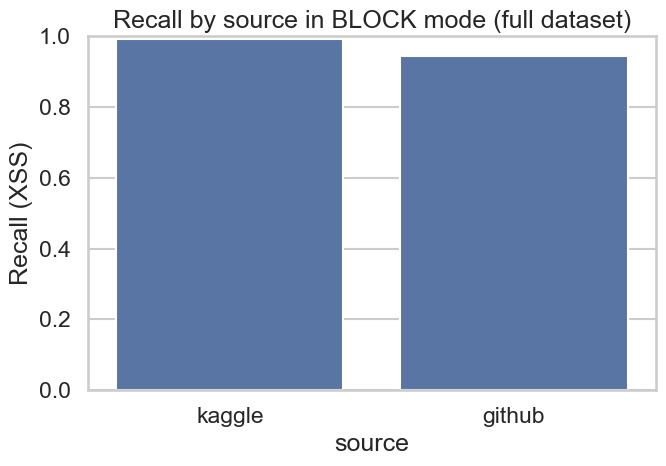

In [8]:
plt.figure(figsize=(7, 5))
sns.barplot(data=df_source_block_full, x="source", y="recall_xss")
plt.title("Recall by source in BLOCK mode (full dataset)")
plt.ylim(0, 1)
plt.xlabel("source")
plt.ylabel("Recall (XSS)")
plt.tight_layout()
plt.show()


In [9]:
feature_flags = ["has_script_tag", "has_event", "has_js_uri", "has_iframe"]

def summarize_by_flag(df_mode: pd.DataFrame, flag: str) -> pd.DataFrame:
    df_eval = df_mode.copy()
    df_eval["y_true"] = df_eval[LABEL_COLUMN].astype(int)
    df_eval["y_pred"] = df_eval["api_blocked"].astype(bool).astype(int)

    rows = []
    for val, g in df_eval.groupby(flag):
        tp = ((g["y_true"] == 1) & (g["y_pred"] == 1)).sum()
        fn = ((g["y_true"] == 1) & (g["y_pred"] == 0)).sum()
        fp = ((g["y_true"] == 0) & (g["y_pred"] == 1)).sum()
        tn = ((g["y_true"] == 0) & (g["y_pred"] == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0

        rows.append(
            {
                flag: bool(val),
                "n": len(g),
                "tp": tp,
                "fn": fn,
                "fp": fp,
                "tn": tn,
                "recall_xss": tpr,
                "fpr": fpr,
            }
        )

    return pd.DataFrame(rows).sort_values(flag, ascending=False)

flag_tables_all: Dict[str, Dict[str, pd.DataFrame]] = {}

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    flag_tables_all[dataset] = {}
    for flag in feature_flags:
        if flag in df_block.columns:
            table = summarize_by_flag(df_block, flag)
            flag_tables_all[dataset][flag] = table

for dataset, flags_dict in flag_tables_all.items():
    print(f"\n================ Dataset: {dataset} ================")
    for flag, table in flags_dict.items():
        print(f"\n=== {flag} ===")
        display(table)



================ Dataset: full ================

=== has_script_tag ===


,has_script_tag,n,tp,fn,fp,tn,recall_xss,fpr
1,True,3408,3394,0,14,0,1.000000,1.000000
0,False,11943,8010,299,134,3500,0.964015,0.036874



=== has_event ===


,has_event,n,tp,fn,fp,tn,recall_xss,fpr
1,True,7782,7745,29,6,2,0.99627,0.750000
0,False,7569,3659,270,142,3498,0.93128,0.039011



=== has_js_uri ===


,has_js_uri,n,tp,fn,fp,tn,recall_xss,fpr
1,True,43,43,0,0,0,1.000000,0.00000
0,False,15308,11361,299,148,3500,0.974357,0.04057



=== has_iframe ===


,has_iframe,n,tp,fn,fp,tn,recall_xss,fpr
1,True,384,384,0,0,0,1.000000,0.00000
0,False,14967,11020,299,148,3500,0.973584,0.04057



================ Dataset: github ================

=== has_script_tag ===


,has_script_tag,n,tp,fn,fp,tn,recall_xss,fpr
1,True,3309,3309,0,0,0,1.00000,0.000000
0,False,1207,838,238,105,26,0.77881,0.801527



=== has_event ===


,has_event,n,tp,fn,fp,tn,recall_xss,fpr
1,True,620,591,29,0,0,0.953226,0.000000
0,False,3896,3556,209,105,26,0.944489,0.801527



=== has_js_uri ===


,has_js_uri,n,tp,fn,fp,tn,recall_xss,fpr
0,False,4516,4147,238,105,26,0.945724,0.801527



=== has_iframe ===


,has_iframe,n,tp,fn,fp,tn,recall_xss,fpr
1,True,327,327,0,0,0,1.00000,0.000000
0,False,4189,3820,238,105,26,0.94135,0.801527



================ Dataset: kaggle ================

=== has_script_tag ===


,has_script_tag,n,tp,fn,fp,tn,recall_xss,fpr
1,True,99,85,0,14,0,1.000000,1.000000
0,False,10736,7172,61,29,3474,0.991566,0.008279



=== has_event ===


,has_event,n,tp,fn,fp,tn,recall_xss,fpr
1,True,7162,7154,0,6,2,1.000000,0.750000
0,False,3673,103,61,37,3472,0.628049,0.010544



=== has_js_uri ===


,has_js_uri,n,tp,fn,fp,tn,recall_xss,fpr
1,True,43,43,0,0,0,1.000000,0.000000
0,False,10792,7214,61,43,3474,0.991615,0.012226



=== has_iframe ===


,has_iframe,n,tp,fn,fp,tn,recall_xss,fpr
1,True,57,57,0,0,0,1.000000,0.000000
0,False,10778,7200,61,43,3474,0.991599,0.012226


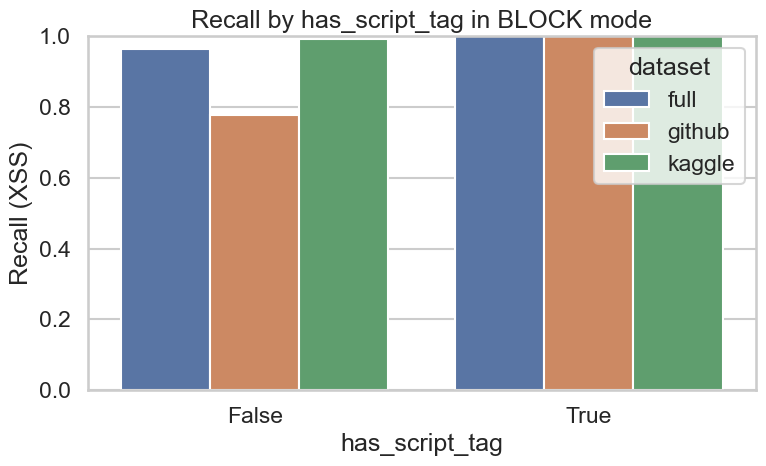

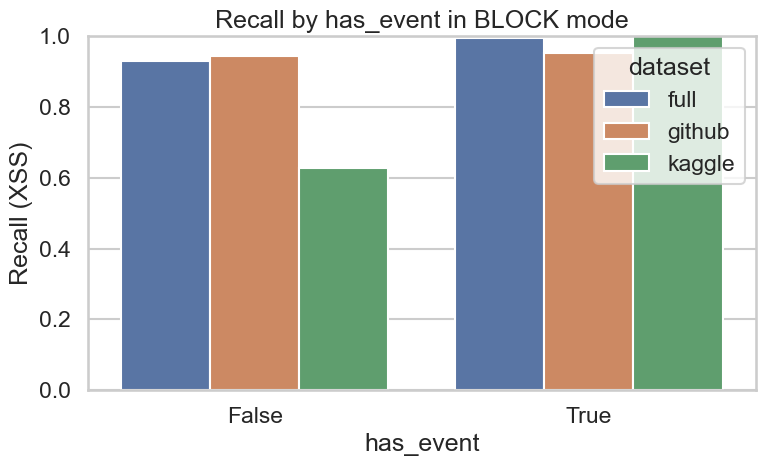

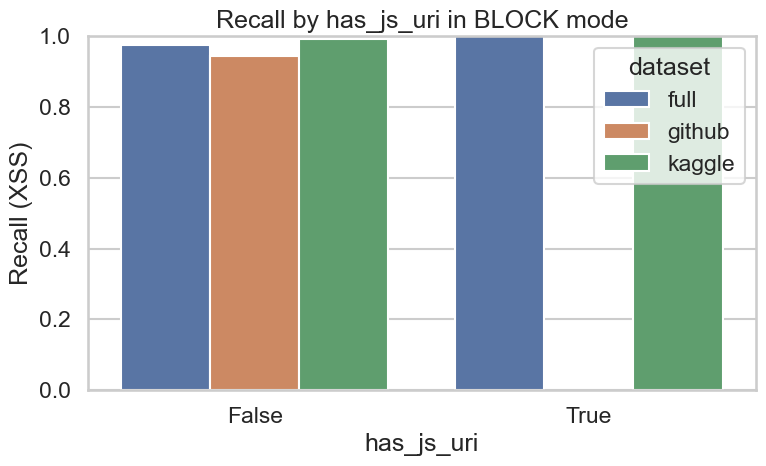

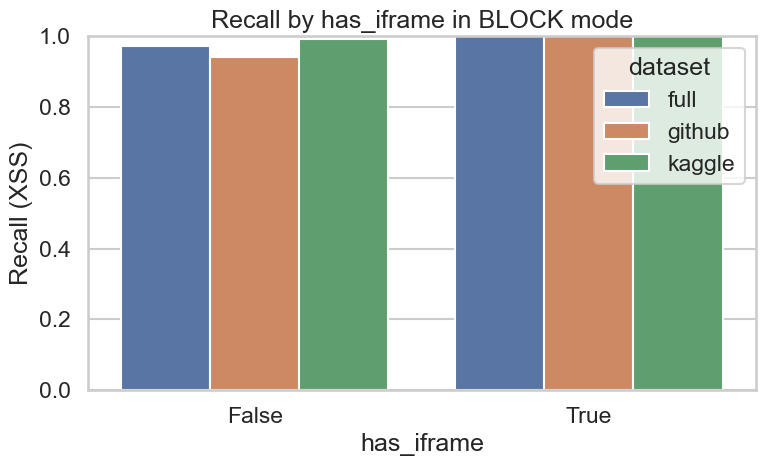

In [10]:
all_flag_rows = []

for dataset, flags_dict in flag_tables_all.items():
    for flag, table in flags_dict.items():
        t = table.copy()
        t["dataset"] = dataset
        t["flag"] = flag
        all_flag_rows.append(t)

df_flags_all = pd.concat(all_flag_rows, ignore_index=True)

for flag in feature_flags:
    df_sub = df_flags_all[df_flags_all["flag"] == flag].copy()
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df_sub,
        x=flag,
        y="recall_xss",
        hue="dataset",
    )
    plt.title(f"Recall by {flag} in BLOCK mode")
    plt.ylim(0, 1)
    plt.xlabel(flag)
    plt.ylabel("Recall (XSS)")
    plt.tight_layout()
    plt.show()


In [11]:
df_github_block = dfs["github"]["block"].copy()

df_github_block["y_true"] = df_github_block[LABEL_COLUMN].astype(int)
df_github_block["y_pred"] = df_github_block["api_blocked"].astype(bool).astype(int)

df_github_block["is_benign"] = df_github_block["y_true"] == 0
df_github_block["is_blocked"] = df_github_block["y_pred"] == 1

df_benign_github = df_github_block[df_github_block["is_benign"]].copy()

df_benign_github.shape


(131, 22)

In [12]:
df_benign_github.groupby("is_blocked").size().reset_index(name="count")


,is_blocked,count
0,False,26
1,True,105


In [13]:
flag_cols = ["has_script_tag", "has_event", "has_js_uri", "has_iframe"]

benign_flag_summary = (
    df_benign_github
    .groupby("is_blocked")[flag_cols]
    .mean()
    .reset_index()
)

benign_flag_summary


,is_blocked,has_script_tag,has_event,has_js_uri,has_iframe
0,False,0.0,0.0,0.0,0.0
1,True,0.0,0.0,0.0,0.0


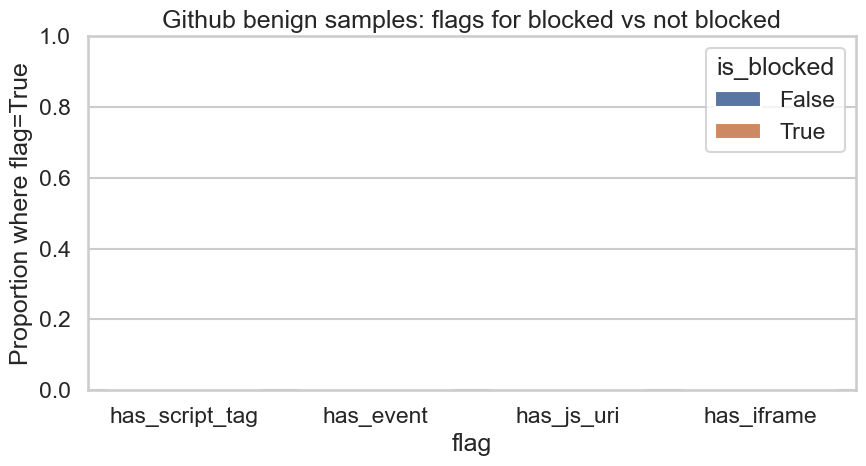

In [14]:
plt.figure(figsize=(9, 5))
sns.barplot(
    data=benign_flag_summary.melt(id_vars="is_blocked", var_name="flag", value_name="ratio_true"),
    x="flag",
    y="ratio_true",
    hue="is_blocked",
)
plt.title("Github benign samples: flags for blocked vs not blocked")
plt.ylim(0, 1)
plt.xlabel("flag")
plt.ylabel("Proportion where flag=True")
plt.tight_layout()
plt.show()


In [15]:
df_benign_github[df_benign_github["is_blocked"] == True].sample(10, random_state=7)[[
    "Sentence_clean",
    "family_main",
    "families_str",
    "has_script_tag",
    "has_event",
    "has_js_uri",
    "has_iframe",
    "api_category"
]]


,Sentence_clean,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,api_category
4185,<a href=#><line xmlns=urn:schemas-microsoft-co...,benign,other,False,False,False,False,scheme
4275,"<form><a href=""javascript:\\\\u0061lert&#x28;1...",benign,other,False,False,False,False,form_tag
4263,"<table background=""javascript:alert('xss')"">",benign,other,False,False,False,False,scheme
4325,<input id=xss onblur=javascript:eval(string['f...,benign,other,False,False,False,False,form_tag
4082,"<a href=""javas\\\\x00cript:javascript:alert(1)...",benign,other,False,False,False,False,scheme
4214,"<xss style=""xss:expression(javascript:alert(1))"">",benign,other,False,False,False,False,scheme
4044,</html onmouseleave>,benign,other,False,False,False,False,html_like
4342,"<meta http-equiv=""link"" content=""<javascript:a...",benign,other,False,False,False,False,meta_tag
2803,<a href=javascript:alert(1)>aaa<a>,benign,other,False,False,False,False,scheme
4186,"<a style=""behavior:url(#default#anchorclick);""...",benign,other,False,False,False,False,scheme


In [16]:
def extract_reasons_matches(row: str) -> pd.Series:
    try:
        obj = json.loads(row)
    except Exception:
        return pd.Series({"reasons": None, "matches": None})
    return pd.Series({
        "reasons": obj.get("reasons"),
        "matches": obj.get("matches"),
    })

df_benign_debug = df_benign_github[df_benign_github["is_blocked"] == True].copy()
df_benign_debug[["reasons", "matches"]] = df_benign_debug["api_raw_json"].apply(extract_reasons_matches)

df_benign_debug.sample(10, random_state=9)[[
    "Sentence_clean",
    "family_main",
    "has_script_tag",
    "has_event",
    "has_js_uri",
    "has_iframe",
    "reasons",
    "matches"
]]


,Sentence_clean,family_main,has_script_tag,has_event,has_js_uri,has_iframe,reasons,matches
4261,"<meta http-equiv=""refresh"" content=""0; url=htt...",benign,False,False,False,False,"[group:meta_tag, group:neutral_polyglot, group...","[{'group': 'meta_tag', 'pattern': '<meta', 'in..."
4170,<style>p[foo=bar{}*{-o-link:'javascript:javasc...,benign,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
4175,<style>*{x:??????????(javascript:alert(1))}</s...,benign,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
4251,"<input type=""image"" src=""javascript:alert('xss...",benign,False,False,False,False,"[group:form_tag, group:neutral_polyglot, group...","[{'group': 'form_tag', 'pattern': '<input', 'i..."
186,<frame name=droite src=http://vuln.xssed.net/t...,benign,False,False,False,False,"[group:active_tag, pattern:<frame]","[{'group': 'active_tag', 'pattern': '<frame', ..."
4161,<a href=java&#1&#2&#3&#4&#5&#6&#7&#8&#11&#12sc...,benign,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
4057,</html onmousedown>,benign,False,False,False,False,"[group:html_like, pattern:</html]","[{'group': 'html_like', 'pattern': '</html', '..."
4044,</html onmouseleave>,benign,False,False,False,False,"[group:html_like, pattern:</html]","[{'group': 'html_like', 'pattern': '</html', '..."
4320,"<form id=""test"" /><button form=""test"" formacti...",benign,False,False,False,False,"[group:dom_sink, group:form_tag, group:scheme,...","[{'group': 'form_tag', 'pattern': '<form', 'in..."
4312,"<style>li {list-style-image: url(""javascript:a...",benign,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."


In [17]:
reason_counts = (
    df_benign_debug["reasons"]
    .dropna()
    .explode()
    .value_counts()
    .reset_index()
    .rename(columns={"index": "reason", "reasons": "count"})
)

reason_counts.head(20)


,reason,count
0,group:scheme,80
1,pattern:alert(,80
2,group:neutral_polyglot,80
3,pattern:javascript:,79
4,group:active_tag,18
5,group:form_tag,12
6,pattern:<meta,10
7,group:meta_tag,10
8,pattern:<input,8
9,"pattern:http-equiv=""refresh",8


In [18]:
def get_error_subsets(df_mode: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    df_eval = df_mode.copy()
    df_eval["y_true"] = df_eval[LABEL_COLUMN].astype(int)
    df_eval["y_pred"] = df_eval["api_blocked"].astype(bool).astype(int)

    mask_tp = (df_eval["y_true"] == 1) & (df_eval["y_pred"] == 1)
    mask_fn = (df_eval["y_true"] == 1) & (df_eval["y_pred"] == 0)
    mask_fp = (df_eval["y_true"] == 0) & (df_eval["y_pred"] == 1)
    mask_tn = (df_eval["y_true"] == 0) & (df_eval["y_pred"] == 0)

    return {
        "tp": df_eval[mask_tp].copy(),
        "fn": df_eval[mask_fn].copy(),
        "fp": df_eval[mask_fp].copy(),
        "tn": df_eval[mask_tn].copy(),
    }

fn_summaries = []

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    subsets = get_error_subsets(df_block)
    df_fn = subsets["fn"]
    if len(df_fn) == 0:
        continue
    summary = (
        df_fn.groupby("family_main")
        .size()
        .reset_index(name="n_fn")
        .sort_values("n_fn", ascending=False)
    )
    summary["dataset"] = dataset
    fn_summaries.append(summary)

df_fn_all = pd.concat(fn_summaries, ignore_index=True) if fn_summaries else pd.DataFrame()
df_fn_all


,family_main,n_fn,dataset
0,benign,270,full
1,event,29,full
2,benign,209,github
3,event,29,github
4,benign,61,kaggle


In [19]:
for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    subsets = get_error_subsets(df_block)
    df_fn = subsets["fn"]
    if len(df_fn) == 0:
        continue
    print(f"\n=== False negatives — dataset={dataset} ===")
    display(
        df_fn[[
            "Sentence_clean",
            "Label",
            "family_main",
            "families_str",
            "has_script_tag",
            "has_event",
            "has_js_uri",
            "has_iframe",
            "api_category"
        ]].head(10)
    )



=== False negatives — dataset=full ===


,Sentence_clean,Label,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,api_category
71,"<A HREF=""http://ha.ckers.org@google""></A>",1,benign,other,False,False,False,False,benign
257,"SRC=""http://ha.ckers.org/.swf"" AllowScriptAcce...",1,benign,other,False,False,False,False,benign
300,header('Location: '.$_GET['param']);,1,benign,maybe_polyglot,False,False,False,False,benign
399,[1].find(alert),1,benign,other,False,False,False,False,benign
516,<a aa aaa aaaa aaaaa aaaaaa aaaaaaa aaaaaaaa a...,1,benign,other,False,False,False,False,benign
519,document.documentURI,1,benign,other,False,False,False,False,benign
520,Set.constructor`alert\\x28document.domain\\x29```,1,benign,other,False,False,False,False,benign
580,document.URL,1,benign,other,False,False,False,False,benign
588,"document.querySelector("".example"")",1,benign,other,False,False,False,False,benign
1203,"document.getElementsByClassName("""").length",1,benign,other,False,False,False,False,benign



=== False negatives — dataset=github ===


,Sentence_clean,Label,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,api_category
2,<marquee>pappy</marquee>&missionary_id=69,1,benign,marquee_tag,False,False,False,False,benign
8,<marquee>pappy washere</marquee>,1,benign,marquee_tag,False,False,False,False,benign
52,<marquee>testicles</marquee>,1,benign,marquee_tag,False,False,False,False,benign
55,<marquee>pappy was here</marquee>,1,benign,marquee_tag,False,False,False,False,benign
77,<marquee>testicles was here</marquee>,1,benign,marquee_tag,False,False,False,False,benign
146,<h1>mouseoverhere!!!!!&report=1,1,benign,header_tag,False,False,False,False,benign
228,"<font size=\\\\""100\\\\"">gurus<marquee>gurus h...",1,benign,marquee_tag|text_container_tag,False,False,False,False,benign
265,"<div style=""background-color:black;width:1000p...",1,benign,text_container_tag,False,False,False,False,benign
272,"<div id=""main_logo""> <img src=""http://www.zmn1...",1,benign,img_tag|text_container_tag,False,False,False,False,benign
300,<h1>ding ding ding ding ding ding</h1><img src...,1,benign,img_tag|header_tag,False,False,False,False,benign



=== False negatives — dataset=kaggle ===


,Sentence_clean,Label,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,api_category
71,"<A HREF=""http://ha.ckers.org@google""></A>",1,benign,other,False,False,False,False,benign
257,"SRC=""http://ha.ckers.org/.swf"" AllowScriptAcce...",1,benign,other,False,False,False,False,benign
300,header('Location: '.$_GET['param']);,1,benign,maybe_polyglot,False,False,False,False,benign
399,[1].find(alert),1,benign,other,False,False,False,False,benign
516,<a aa aaa aaaa aaaaa aaaaaa aaaaaaa aaaaaaaa a...,1,benign,other,False,False,False,False,benign
519,document.documentURI,1,benign,other,False,False,False,False,benign
520,Set.constructor`alert\\x28document.domain\\x29```,1,benign,other,False,False,False,False,benign
580,document.URL,1,benign,other,False,False,False,False,benign
588,"document.querySelector("".example"")",1,benign,other,False,False,False,False,benign
1203,"document.getElementsByClassName("""").length",1,benign,other,False,False,False,False,benign


In [20]:
def extract_score_features(row: str) -> pd.Series:
    try:
        obj = json.loads(row)
    except Exception:
        return pd.Series({"n_matches": 0, "n_groups": 0})
    matches = obj.get("matches") or []
    groups = [m.get("group") for m in matches if isinstance(m, dict)]
    groups = [g for g in groups if g is not None]
    n_matches = len(matches)
    n_groups = len(set(groups))
    return pd.Series({"n_matches": n_matches, "n_groups": n_groups})

score_results: Dict[str, pd.DataFrame] = {}

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    df_block = df_block.copy()
    df_block[["n_matches", "n_groups"]] = df_block["api_raw_json"].apply(extract_score_features)
    score_results[dataset] = df_block

score_results["full"][["n_matches", "n_groups"]].describe()


,n_matches,n_groups
count,15351.000000,15351.000000
mean,1.571494,1.330141
std,1.300496,1.023020
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,2.000000
max,13.000000,7.000000


In [21]:
def compute_metrics_for_thresholds(df_scores: pd.DataFrame, label_col: str, score_col: str, thresholds: List[int]) -> pd.DataFrame:
    rows = []
    y_true = df_scores[label_col].astype(int)
    for thr in thresholds:
        y_pred = (df_scores[score_col] >= thr).astype(int)
        tp = ((y_true == 1) & (y_pred == 1)).sum()
        fn = ((y_true == 1) & (y_pred == 0)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        tn = ((y_true == 0) & (y_pred == 0)).sum()

        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0
        precision = tp / (tp + fp) if (tp + fp) else 0.0
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0.0

        rows.append(
            {
                "threshold": thr,
                "tp": tp,
                "fn": fn,
                "fp": fp,
                "tn": tn,
                "recall_xss": tpr,
                "fpr": fpr,
                "precision": precision,
                "f1": f1,
            }
        )
    return pd.DataFrame(rows)

thresholds = [1, 2, 3]

tradeoff_tables: Dict[str, Dict[str, pd.DataFrame]] = {}

for dataset, df_scores in score_results.items():
    tradeoff_tables[dataset] = {}
    for score_col in ["n_matches", "n_groups"]:
        table = compute_metrics_for_thresholds(df_scores, LABEL_COLUMN, score_col, thresholds)
        table["dataset"] = dataset
        table["score_type"] = score_col
        tradeoff_tables[dataset][score_col] = table

df_tradeoff_all = pd.concat(
    [t for d in tradeoff_tables.values() for t in d.values()],
    ignore_index=True
)
df_tradeoff_all


,threshold,tp,fn,fp,tn,recall_xss,fpr,precision,f1,dataset,score_type
0,1,11404,299,148,3500,0.974451,0.040570,0.987188,0.980778,full,n_matches
1,2,6940,4763,100,3548,0.593010,0.027412,0.985795,0.740543,full,n_matches
2,3,4198,7505,34,3614,0.358711,0.009320,0.991966,0.526890,full,n_matches
3,1,11404,299,148,3500,0.974451,0.040570,0.987188,0.980778,full,n_groups
4,2,6626,5077,82,3566,0.566180,0.022478,0.987776,0.719787,full,n_groups
5,3,1811,9892,32,3616,0.154747,0.008772,0.982637,0.267385,full,n_groups
6,1,4147,238,105,26,0.945724,0.801527,0.975306,0.960287,github,n_matches
7,2,3873,512,86,45,0.883238,0.656489,0.978277,0.928332,github,n_matches
8,3,3390,995,34,97,0.773090,0.259542,0.990070,0.868229,github,n_matches
9,1,4147,238,105,26,0.945724,0.801527,0.975306,0.960287,github,n_groups


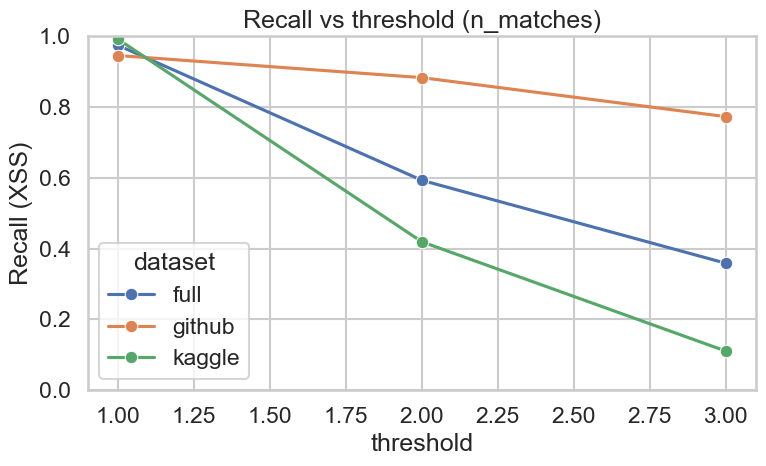

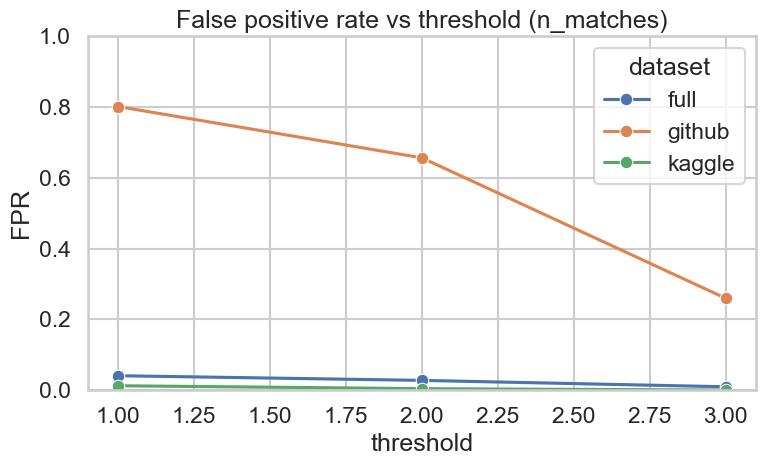

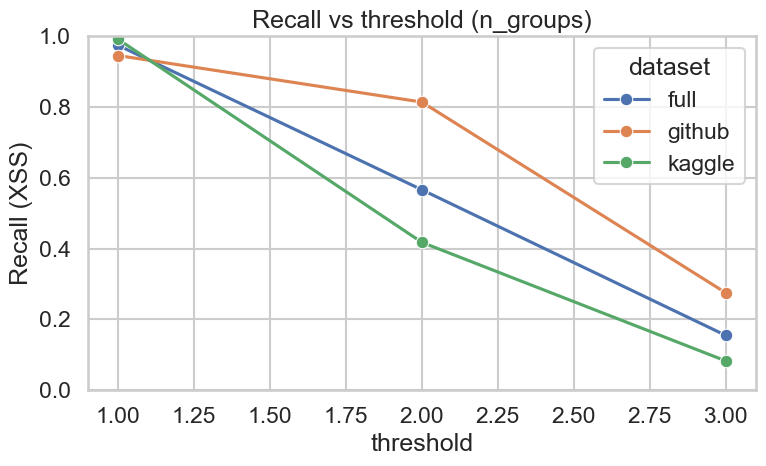

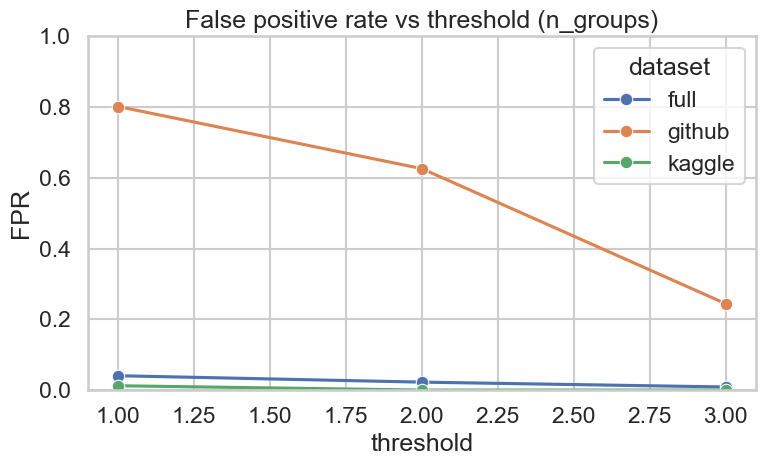

In [22]:
for score_col in ["n_matches", "n_groups"]:
    df_sub = df_tradeoff_all[df_tradeoff_all["score_type"] == score_col].copy()
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df_sub,
        x="threshold",
        y="recall_xss",
        hue="dataset",
        marker="o",
    )
    plt.title(f"Recall vs threshold ({score_col})")
    plt.ylim(0, 1)
    plt.xlabel("threshold")
    plt.ylabel("Recall (XSS)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=df_sub,
        x="threshold",
        y="fpr",
        hue="dataset",
        marker="o",
    )
    plt.title(f"False positive rate vs threshold ({score_col})")
    plt.ylim(0, 1)
    plt.xlabel("threshold")
    plt.ylabel("FPR")
    plt.tight_layout()
    plt.show()


In [23]:
crosstabs: Dict[str, pd.DataFrame] = {}

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    ct = pd.crosstab(df_block[LABEL_COLUMN], df_block["api_category"])
    crosstabs[dataset] = ct
    print(f"\n=== Label vs api_category — dataset={dataset} ===")
    display(ct)



=== Label vs api_category — dataset=full ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,18,3500,4,0,24,15,1,18,6,46,16
1,906,299,25,1509,307,280,405,56,4549,63,3304



=== Label vs api_category — dataset=github ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,18,26,3,0,12,7,1,10,6,46,2
1,274,238,17,154,17,160,246,1,9,40,3229



=== Label vs api_category — dataset=kaggle ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,0,3474,1,0,12,8,0,8,0,0,14
1,632,61,8,1355,290,120,159,55,4540,23,75


In [24]:
for dataset, ct in crosstabs.items():
    row_norm = ct.div(ct.sum(axis=1), axis=0)
    print(f"\n=== Row-normalized Label vs api_category — dataset={dataset} ===")
    display(row_norm.round(3))



=== Row-normalized Label vs api_category — dataset=full ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,0.005,0.959,0.001,0.000,0.007,0.004,0.000,0.005,0.002,0.013,0.004
1,0.077,0.026,0.002,0.129,0.026,0.024,0.035,0.005,0.389,0.005,0.282



=== Row-normalized Label vs api_category — dataset=github ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,0.137,0.198,0.023,0.000,0.092,0.053,0.008,0.076,0.046,0.351,0.015
1,0.062,0.054,0.004,0.035,0.004,0.036,0.056,0.000,0.002,0.009,0.736



=== Row-normalized Label vs api_category — dataset=kaggle ===


api_category,active_tag,benign,dom_sink,event,form_tag,html_like,image_tag,meta_tag,neutral_polyglot,scheme,script_tag
Label,,,,,,,,,,,
0,0.000,0.988,0.000,0.000,0.003,0.002,0.000,0.002,0.00,0.000,0.004
1,0.086,0.008,0.001,0.185,0.040,0.016,0.022,0.008,0.62,0.003,0.010


In [25]:
length_results = []

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    subsets = get_error_subsets(df_block)
    for label, df_sub in subsets.items():
        tmp = df_sub[["len_after_clean"]].copy()
        tmp["dataset"] = dataset
        tmp["subset"] = label
        length_results.append(tmp)

df_length_all = pd.concat(length_results, ignore_index=True)
df_length_all.groupby(["dataset", "subset"])["len_after_clean"].describe()


count        mean         std   min    25%    50%     75%  \
dataset subset                                                                
full    fn        299.0  148.096990  366.001486   5.0  33.00   56.0   90.50   
        fp        148.0  100.202703  175.004294   6.0  46.00   59.5   79.50   
        tn       3500.0  248.500857  330.812833   5.0  83.00  106.0  270.00   
        tp      11404.0   76.358032  107.838677  11.0  43.00   55.0   79.00   
github  fn        238.0  173.407563  405.317677   5.0  38.25   61.5   95.75   
        fp        105.0  106.066667  186.723277   8.0  48.00   63.0   79.00   
        tn         26.0  151.538462  330.591619   8.0  18.50   26.0   86.75   
        tp       4147.0  100.315891  171.088240  12.0  43.00   62.0   95.00   
kaggle  fn         61.0   49.344262   62.839978   5.0  18.00   32.0   47.00   
        fp         43.0   85.883721  143.398248   6.0  42.00   57.0   82.00   
        tn       3474.0  249.226540  330.754869   5.0  83.25  107.0  271.75   
        tp       7257.0   62.667356   32.168723  11.0  42.00   53.0   65.00   

                   max  
dataset subset          
full    fn      2686.0  
        fp      1407.0  
        tn      2587.0  
        tp      2854.0  
github  fn      2686.0  
        fp      1407.0  
        tn      1452.0  
        tp      2854.0  
kaggle  fn       408.0  
        fp       962.0  
        tn      2587.0  
        tp       425.0

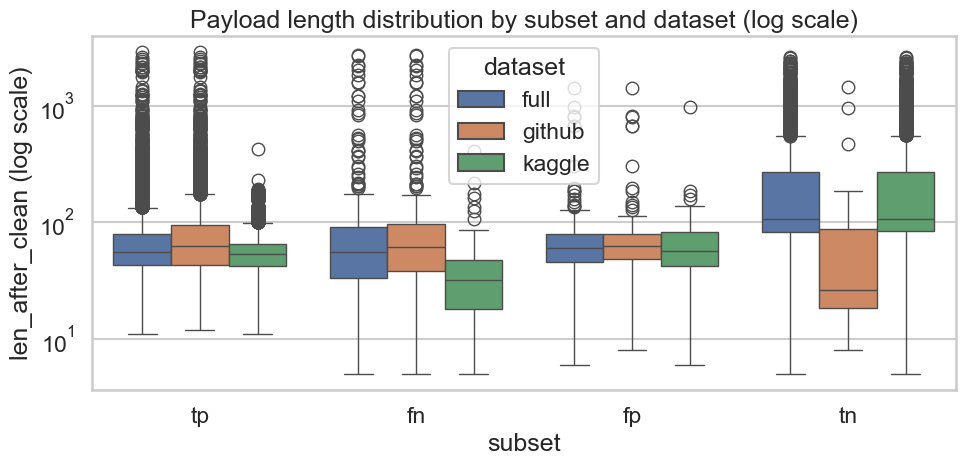

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_length_all,
    x="subset",
    y="len_after_clean",
    hue="dataset",
)
plt.yscale("log")
plt.title("Payload length distribution by subset and dataset (log scale)")
plt.xlabel("subset")
plt.ylabel("len_after_clean (log scale)")
plt.tight_layout()
plt.show()


In [27]:
# Analysis of reasons/matches in errors + small case-study tables

def extract_reasons_matches(row: str) -> pd.Series:
    """
    Extrae 'reasons' y 'matches' del JSON crudo de la API.
    Si algo falla, devuelve None en ambos campos.
    """
    try:
        obj = json.loads(row)
    except Exception:
        return pd.Series({"reasons": None, "matches": None})
    return pd.Series({
        "reasons": obj.get("reasons"),
        "matches": obj.get("matches"),
    })

In [28]:
# 1) False negatives: qué patrones detecta pero no bloquea
#    (case study para la familia 'benign')

fn_rows: List[pd.DataFrame] = []

for dataset, modes in dfs.items():
    df_block = modes["block"].copy()
    df_block["y_true"] = df_block[LABEL_COLUMN].astype(int)
    df_block["y_pred"] = df_block["api_blocked"].astype(bool).astype(int)

    # Falsos negativos: Label=1 (XSS) pero api_blocked=0
    df_fn = df_block[(df_block["y_true"] == 1) & (df_block["y_pred"] == 0)].copy()
    if df_fn.empty:
        continue

    # Extraer reasons/matches del JSON de la API
    df_fn[["reasons", "matches"]] = df_fn["api_raw_json"].apply(extract_reasons_matches)
    df_fn["dataset"] = dataset
    fn_rows.append(df_fn)

if fn_rows:
    df_fn_all = pd.concat(fn_rows, ignore_index=True)

    # Nos quedamos solo con la familia 'benign' (mal rotulada / difícil)
    df_fn_benign = df_fn_all[df_fn_all["family_main"] == "benign"].copy()

    fn_benign_case_study = (
        df_fn_benign
        .sample(min(10, len(df_fn_benign)), random_state=7)[[
            "dataset",
            "Sentence_clean",
            "family_main",
            "families_str",
            "has_script_tag",
            "has_event",
            "has_js_uri",
            "has_iframe",
            "reasons",
            "matches",
        ]]
        .reset_index(drop=True)
    )

    print("\n=== False Negative 'benign family' — Case Study (up to 10 samples) ===")
    display(fn_benign_case_study)
else:
    print("No false negatives found in BLOCK mode.")


=== False Negative 'benign family' — Case Study (up to 10 samples) ===


,dataset,Sentence_clean,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,reasons,matches
0,kaggle,document.documentURI,benign,other,False,False,False,False,[],[]
1,full,<font size=70 color=red>� audisoft+hacker+team...,benign,text_container_tag,False,False,False,False,[],[]
2,github,<img>,benign,img_tag,False,False,False,False,[],[]
3,github,<h1>rubberduck</h1><br><br><marquee>whitehat+f...,benign,marquee_tag|header_tag,False,False,False,False,[],[]
4,github,<div style=z-index:1000;width:2000px;height:20...,benign,text_container_tag,False,False,False,False,[],[]
5,full,[1].find(alert),benign,other,False,False,False,False,[],[]
6,full,"=""background-image:\\0075\\0072\\006C\\0028'\\...",benign,other,False,False,False,False,[],[]
7,github,<marquee>pappy</marquee>&missionary_id=69,benign,marquee_tag,False,False,False,False,[],[]
8,github,<marquee><h1><strong>cueballr</strong></h1></m...,benign,marquee_tag|header_tag,False,False,False,False,[],[]
9,github,<marquee><h1>defaced+by+ironzorg</h1></marquee>,benign,marquee_tag|header_tag,False,False,False,False,[],[]


In [29]:
# 2) GitHub false positives: benign samples que son bloqueados
#    (case study con reasons/matches)

df_github_block = dfs["github"]["block"].copy()
df_github_block["y_true"] = df_github_block[LABEL_COLUMN].astype(int)
df_github_block["y_pred"] = df_github_block["api_blocked"].astype(bool).astype(int)

# Falsos positivos: Label=0 (benigno) pero api_blocked=1
df_github_fp = df_github_block[
    (df_github_block["y_true"] == 0) & (df_github_block["y_pred"] == 1)
].copy()

df_github_fp[["reasons", "matches"]] = df_github_fp["api_raw_json"].apply(extract_reasons_matches)

github_fp_case_study = (
    df_github_fp
    .sample(min(10, len(df_github_fp)), random_state=42)[[
        "Sentence_clean",
        "family_main",
        "families_str",
        "has_script_tag",
        "has_event",
        "has_js_uri",
        "has_iframe",
        "reasons",
        "matches",
    ]]
    .reset_index(drop=True)
)

print("\n=== GitHub False Positives — Case Study (up to 10 samples) ===")
display(github_fp_case_study)


=== GitHub False Positives — Case Study (up to 10 samples) ===


,Sentence_clean,family_main,families_str,has_script_tag,has_event,has_js_uri,has_iframe,reasons,matches
0,<input onblur=javascript:alert(1) autofocus><i...,benign,other,False,False,False,False,"[group:event, group:form_tag, group:neutral_po...","[{'group': 'form_tag', 'pattern': '<input', 'i..."
1,<style>a{background:url('s1' 's2)}@import java...,benign,other,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
2,"<form id=""test"" /><button form=""test"" formacti...",benign,other,False,False,False,False,"[group:form_tag, group:neutral_polyglot, group...","[{'group': 'form_tag', 'pattern': '<form', 'in..."
3,"<br size=""&{javascript:alert(1)}"">",benign,other,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
4,<// style=x:expression\\\\28javascript:alert(1...,benign,other,False,False,False,False,"[group:neutral_polyglot, group:scheme, pattern...","[{'group': 'scheme', 'pattern': 'javascript:',..."
5,"<meta http-equiv=""link"" content=""<javascript:a...",benign,other,False,False,False,False,"[group:meta_tag, group:neutral_polyglot, group...","[{'group': 'meta_tag', 'pattern': '<meta', 'in..."
6,<embed src=javascript:alert(1)>,benign,other,False,False,False,False,"[group:active_tag, group:neutral_polyglot, gro...","[{'group': 'active_tag', 'pattern': '<embed', ..."
7,"<meta charset=""mac-farsi"">¼script¾javascript:a...",benign,other,False,False,False,False,"[group:meta_tag, group:neutral_polyglot, group...","[{'group': 'meta_tag', 'pattern': '<meta', 'in..."
8,"script>alert(""cyber_thief(turkey) hackhaber.co...",benign,other,False,False,False,False,"[group:neutral_polyglot, group:script_tag, pat...","[{'group': 'script_tag', 'pattern': '</script'..."
9,"<frame src=""javascript:alert('pappy was here')...",benign,other,False,False,False,False,"[group:active_tag, group:neutral_polyglot, gro...","[{'group': 'active_tag', 'pattern': '<frame', ..."


In [ ]:
# !jupytext --to notebook 07_xss_api_evaluation.py

[jupytext] Reading 07_xss_api_evaluation.py in format py
[jupytext] Writing 07_xss_api_evaluation.ipynb
